In [8]:
import numpy as np
import pandas as pd
import random
import keras
import os
import math

from keras.models import Sequential
from keras.layers import Dense, Flatten, Reshape, Dropout
from keras.layers.convolutional import Conv2D, MaxPooling2D,ZeroPadding2D
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import concatenate,BatchNormalization,Activation
from keras.utils import plot_model

import scipy.io
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import matplotlib.gridspec as gridspec
from datetime import datetime

from keras.layers import Conv2D, LeakyReLU
from keras.callbacks import EarlyStopping
from keras import regularizers
import tensorflow as tf
from keras.optimizers import SGD
import cv2, numpy as np

In [9]:
src = 'data/'
save = 'save/'
files = os.listdir(src)


In [3]:
def MAE(y_true, y_pred):     
    
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    return np.mean(np.abs((y_true - y_pred)))

count = 0
now = datetime.now() 
name =str(now.year)+'_'+str(now.month)+'_'+str(now.day)+'_'+str(now.hour)

In [4]:
csv_test = pd.read_csv(src+'train.csv')
x = csv_test.iloc[:,4:-1].values
y = csv_test.iloc[:,0:4].values

X_train, X_test, Y_train, Y_test = train_test_split(x,y, test_size=0.001, random_state=1,shuffle=True)

In [5]:
sc = MinMaxScaler()

X_train_scale=sc.fit_transform(X_train)
Y_train_scale=sc.fit_transform(Y_train)
X_test_scale=sc.fit_transform(X_test)
Y_test_scale=sc.fit_transform(Y_test)

In [15]:
np.shape(X_train[0])

(225,)

In [6]:
np.shape(X_train_scale)
X_train_scale_reshape = X_train_scale.reshape(809190, 225,1,1)
X_train_scale_reshape = X_test_scale.reshape(810, 225,1,1)
X_train_reshape = X_train.reshape(809190, 225,1,1)
X_test_reshape = X_test.reshape(810, 225,1,1)
print(np.shape(X_train_scale))

(809190, 225)


In [38]:
leaky_relu = tf.nn.leaky_relu

def CNN(weights_path=None):

    model = Sequential()
    #model.add(ZeroPadding2D((1,0),input_shape=(225,1,1)))
    model.add(Conv2D(112, 3, 1, activation='relu',input_shape=(225,1,1)))
    model.add(Activation(leaky_relu))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2,1), strides=(1,2)))
    model.add(Conv2D(224, 3, 1,activation='relu'))
    model.add(Activation(leaky_relu))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2,1), strides=(1,2)))
    model.add(Conv2D(448, 4, 1,activation ='relu'))
    model.add(Activation(leaky_relu))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(102, activation='relu'))
    model.add(Dropout(0.7))
    model.add(Dense(4, activation='linear'))

    return model

def NN(weights_path=None):

    model = Sequential()
    model.add(Dense(300, activation='relu',input_shape=(225,)))
    model.add(Dense(300, activation='relu'))
    model.add(Dense(600, activation='relu'))
    model.add(Dense(600, activation='relu'))
    model.add(Dense(1000, activation='relu'))
    model.add(Dense(1000, activation='relu'))
    model.add(Dense(1000, activation='relu'))
    model.add(Dense(4, activation='linear'))

    return model

model=NN()
model.summary()
#pyplot_model(model, to_file=save+str(count)+'_Architecture_'+name+'.png', show_shapes=True)

adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)

model.compile(optimizer= adam , loss='mse', metrics=['mae','accuracy'])
early_stopping = EarlyStopping(patience=10)

hist = model.fit(X_train, Y_train_scale, batch_size=128, epochs=100,validation_split=0.01,callbacks=[early_stopping],verbose=1)

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_52 (Dense)             (None, 300)               67800     
_________________________________________________________________
dense_53 (Dense)             (None, 300)               90300     
_________________________________________________________________
dense_54 (Dense)             (None, 600)               180600    
_________________________________________________________________
dense_55 (Dense)             (None, 600)               360600    
_________________________________________________________________
dense_56 (Dense)             (None, 1000)              601000    
_________________________________________________________________
dense_57 (Dense)             (None, 1000)              1001000   
_________________________________________________________________
dense_58 (Dense)             (None, 1000)            

['loss', 'mae', 'accuracy']
[0.0012730151078560285, 0.0236677099019289, 0.9382715821266174]


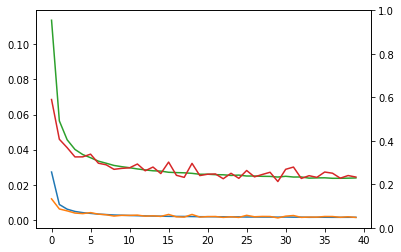

In [39]:
score = model.evaluate(X_test, Y_test_scale, verbose=0)
np.savetxt(save+str(count)+'_Score_'+name+'.txt', score)

print(model.metrics_names)
print(score)

fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'],label='train loss')
loss_ax.plot(hist.history['val_loss'],label='val_loss')
loss_ax.plot(hist.history['mae'],label='train acc')
loss_ax.plot(hist.history['val_mae'],label='val acc')
plt.savefig(save+str(count)+'_Train_curve_'+name+'.png', dpi=300)

In [37]:
Y_hat_test = abs(model.predict(X_test,batch_size=32))
Y_hat_test_inverse = sc.inverse_transform(Y_hat_test)
Y_test_inverse = sc.inverse_transform(Y_test_scale)

record_pred = []


for i in range(100):

  Y_hat= list(map(int, Y_hat_test_inverse[i]))
  print(i,'real:',Y_test_inverse[i],'pred:',Y_hat,' ',sep='\n')
  Y_append= np.append(Y_test_inverse[i],Y_hat)
  record_pred.append(Y_append)  

np.savetxt(save+str(count)+'_Record pred_'+name+'.csv', record_pred,delimiter=',')
model.save_weights(save+str(count)+"_Weight_"+name+".h5")

record_mae = []
pred_shape = np.shape(record_pred)
for i in range(pred_shape[0]):
    record_mae.append(MAE(record_pred[i][0:4],record_pred[i][4:]))

final_metric = np.mean(record_mae)

print('final mean_absolute_error:',final_metric)

0
real:
[170. 170. 250. 190.]
pred:
[177, 161, 249, 196]
 
1
real:
[220. 140. 160. 180.]
pred:
[218, 135, 151, 178]
 
2
real:
[ 60. 150.  20. 210.]
pred:
[40, 142, 71, 166]
 
3
real:
[ 40. 180.  50.  60.]
pred:
[47, 175, 45, 70]
 
4
real:
[ 60.  30. 150. 180.]
pred:
[60, 39, 146, 188]
 
5
real:
[270. 270.  10.  30.]
pred:
[259, 253, 11, 30]
 
6
real:
[ 70.  90. 210.  50.]
pred:
[66, 89, 216, 38]
 
7
real:
[ 70. 180. 200. 170.]
pred:
[68, 175, 192, 171]
 
8
real:
[ 20.  90. 210. 260.]
pred:
[14, 95, 206, 260]
 
9
real:
[ 50. 250.  60. 150.]
pred:
[50, 241, 58, 152]
 
10
real:
[270.  20. 110. 200.]
pred:
[265, 12, 109, 212]
 
11
real:
[120. 180.  50. 240.]
pred:
[125, 168, 59, 240]
 
12
real:
[150.  40.  10.  90.]
pred:
[144, 26, 12, 110]
 
13
real:
[290. 220.  80. 210.]
pred:
[296, 212, 76, 208]
 
14
real:
[150. 160. 100.  20.]
pred:
[158, 171, 94, 25]
 
15
real:
[180. 170. 240. 190.]
pred:
[179, 167, 230, 196]
 
16
real:
[180. 190.  20. 190.]
pred:
[181, 162, 26, 198]
 
17
real:
[160. 

In [ ]:
model_json = model.to_json()

with open("model.json", "w") as json_file : 
    json_file.write(model_json)

model.save_weights("model.h5")
print("Saved model to disk")

from keras.models import model_from_json 

json_file = open("model.json", "r") 
loaded_model_json = json_file.read() 
json_file.close() 
loaded_model = model_from_json(loaded_model_json)

loaded_model.load_weights("model.h5") 
print("Loaded model from disk")

loaded_model.compile(loss="mse", optimizer="adam", metrics=['mae'])

# model evaluation

score = loaded_model.evaluate(X_test_scale,Y_test_scale,verbose=0)
print("%s : %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))